Trabalho sobre análise exploratória de dados utilizando Python, Linguagem SQL e Banco de Dados SQLite. 
Os dados utilizados nesse projeto são dados reais, disponíveis a partir do IMDB.

Realizando a instalação e carregamento dos pacotes a serem utilizados

In [5]:
# Instalando o pacote
!pip install -q imdb-sqlite

In [6]:
# instalando o pacote pycountry (nomes dos paises, etc...)
!pip install -q pycountry

In [7]:
# Importando pacotes para realização das análises numéricas

import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

Carregamento dos Dados utilizados

In [8]:
%%time
!imdb-sqlite

2022-03-16 22:48:45,407 DB already exists: (imdb.db). Refusing to modify. Exiting
CPU times: user 3.81 ms, sys: 8.62 ms, total: 12.4 ms
Wall time: 206 ms


In [9]:
# abrindo conexão ao banco de dados
conn = sqlite3.connect("imdb.db")

In [10]:
# Realizando a extração das listas de tabelas
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type = 'table'", conn)

In [11]:
# type(tabelas)
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [12]:
tabelas = tabelas["Table_Name"].values.tolist()

In [13]:
# Verificando o esquema de cada tabela
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da tabela:", tabela)
    display(resultado)
    print("-"*100)
    print("\n")

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




Primeira parte - Quais as categorias de filmes mais comuns no IMDB ?

In [14]:
# Criando a primeira consulta 
consulta1 = '''SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type'''

In [15]:
resultado1 = pd.read_sql_query(consulta1, conn)

In [16]:
# Total com base na categoria
display(resultado1)

,type,COUNT
0,movie,604670
1,short,860393
2,tvEpisode,6569786
3,tvMiniSeries,42557
4,tvMovie,135370
5,tvPilot,2
6,tvSeries,222271
7,tvShort,10503
8,tvSpecial,36277
9,video,258022


In [17]:
# Além de calcular o percentual, é necessário criar uma coluna nova
resultado1['percentual'] = (resultado1['COUNT'] / resultado1['COUNT'].sum()) * 100

In [18]:
display(resultado1)

,type,COUNT,percentual
0,movie,604670,6.894400
1,short,860393,9.810134
2,tvEpisode,6569786,74.908189
3,tvMiniSeries,42557,0.485232
4,tvMovie,135370,1.543478
5,tvPilot,2,0.000023
6,tvSeries,222271,2.534317
7,tvShort,10503,0.119754
8,tvSpecial,36277,0.413628
9,video,258022,2.941947


In [19]:
# Filtrando apenas 4 categorias. 3 categorias com mais títulos e 1 categorias com o restante
others = {}

others['COUNT'] = resultado1[resultado1['percentual'] < 5]['COUNT'].sum()

others['percentual'] = resultado1[resultado1['percentual'] < 5]['percentual'].sum()

others['type'] = 'others'

In [20]:
others

{'COUNT': 735602, 'percentual': 8.387276777442802, 'type': 'others'}

In [21]:
resultado1 = resultado1[resultado1['percentual'] > 5]

In [22]:
resultado1 = resultado1.append(others, ignore_index=True)

In [23]:
resultado1 = resultado1.sort_values(by = 'COUNT', ascending=False)

In [24]:
resultado1.head()

,type,COUNT,percentual
2,tvEpisode,6569786,74.908189
1,short,860393,9.810134
3,others,735602,8.387277
0,movie,604670,6.894400


In [25]:
labels = [str(resultado1['type'][i])+' '+'['+str(round(resultado1['percentual'][i],2)) +'%'+']' for i in resultado1.index]

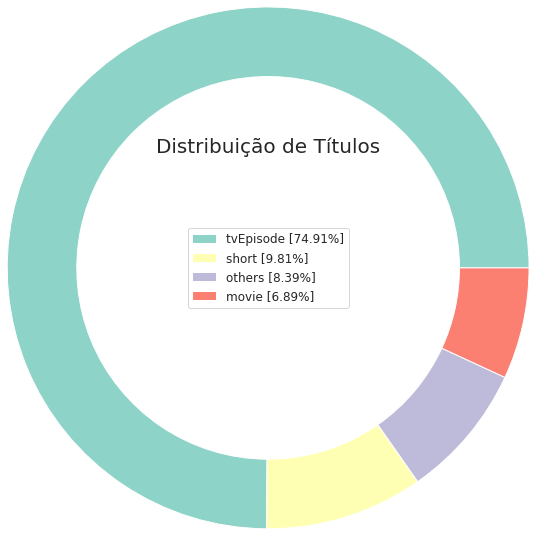

In [26]:
#Plot

cs = cm.Set3(np.arange(100))

f = plt.figure()

plt.pie(resultado1['COUNT'], labeldistance=1, radius=3, colors=cs, wedgeprops= dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title("Distribuição de Títulos", loc = 'Center', fontdict={'fontsize': 20, 'fontweight': 20})
plt.show()

Segunda Parte - Qual o número de títulos por gêneros ???

In [27]:
consulta2 = '''SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres'''

In [28]:
resultado2 = pd.read_sql_query(consulta2, conn)

In [29]:
display(resultado2)

,genres,COUNT(*)
0,Action,13891
1,"Action,Adult",11
2,"Action,Adult,Adventure",1
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1448,"Thriller,Western",44
1449,War,1291
1450,"War,Western",14
1451,Western,5137


In [30]:
# O '#' acima pode indicar que temos filmes que não possuem um genero definido
resultado2['genres'] = resultado2['genres'].str.lower().values

In [31]:
temp = resultado2['genres'].dropna()

In [32]:
# Neste ponto foi apresentado o conceito do one-hot encoded
padrao = '(?u)\\b[\\w-]+\\b'
vetor = CountVectorizer(token_pattern= padrao, analyzer='word').fit(temp)

In [33]:
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [34]:
bag_generos = vetor.transform(temp)

In [35]:
type(bag_generos)

scipy.sparse.csr.csr_matrix

In [38]:
generos_unicos = vetor.get_feature_names()

In [39]:
generos = pd.DataFrame(bag_generos.todense(), columns=generos_unicos, index=temp.index)

In [40]:
generos.info

<bound method DataFrame.info of       action  adult  adventure  animation  biography  comedy  crime  \
0          1      0          0          0          0       0      0   
1          1      1          0          0          0       0      0   
2          1      1          1          0          0       0      0   
3          1      1          0          0          0       1      0   
4          1      1          0          0          0       0      1   
...      ...    ...        ...        ...        ...     ...    ...   
1448       0      0          0          0          0       0      0   
1449       0      0          0          0          0       0      0   
1450       0      0          0          0          0       0      0   
1451       0      0          0          0          0       0      0   
1452       0      0          0          0          0       0      0   

      documentary  drama  family  ...  news  reality-tv  romance  sci-fi  \
0               0      0       0  ...  

In [41]:
generos = generos.drop(columns = 'n', axis=0)

In [42]:
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending=False) / generos.shape[0]

In [43]:
generos_percentual.head(10)

drama          18.169305
comedy         16.792842
documentary    15.829319
adventure      14.796972
action         14.452856
romance        13.282863
crime          13.076394
mystery        12.525809
thriller       12.319339
fantasy        12.181693
dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

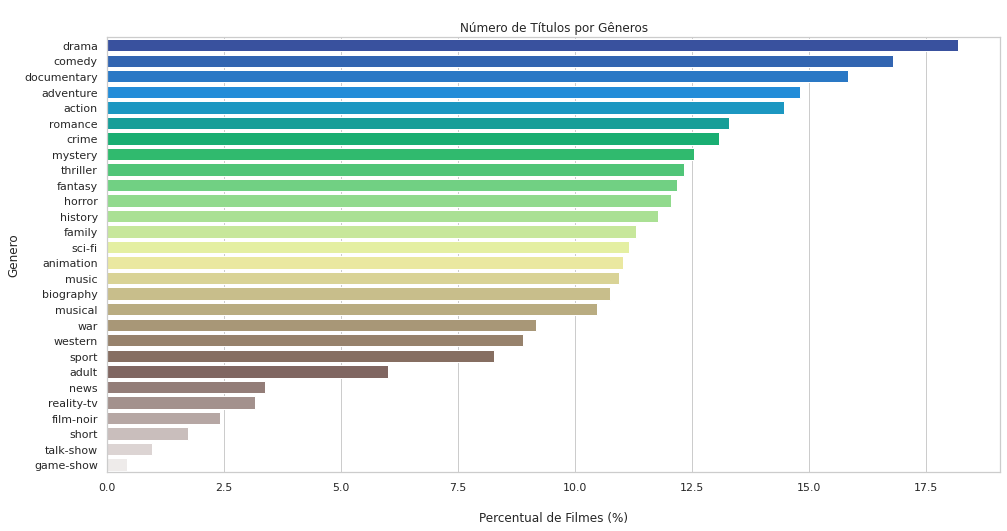

In [44]:
plt.figure(figsize = (16,8))
sns.barplot(x=generos_percentual.values, y=generos_percentual.index, orient="h", palette="terrain")
plt.ylabel('Genero')
plt.xlabel("\nPercentual de Filmes (%)")
plt.title("\nNúmero de Títulos por Gêneros")
plt.show